<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:00:47] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


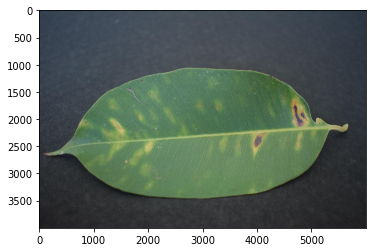

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

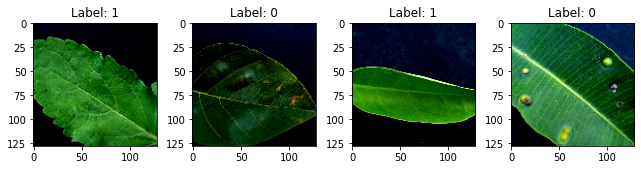

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:00:54] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:00:56] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2408617151125574 samples/sec                   batch loss = 1.266548991203308 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2601131661240697 samples/sec                   batch loss = 0.48265963792800903 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2622572121606086 samples/sec                   batch loss = 0.3852195739746094 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2591078888544083 samples/sec                   batch loss = 0.24458646774291992 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2551810809381245 samples/sec                   batch loss = 0.5477595925331116 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.2542721670519197 samples/sec                   batch loss = 0.25303915143013 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2519213615165359 samples/sec                   batch loss = 0.6456836462020874 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2570853722837712 samples/sec                   batch loss = 0.8784334659576416 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2569441015827312 samples/sec                   batch loss = 0.581818699836731 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.261501057904311 samples/sec                   batch loss = 0.5737536549568176 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2700198331592254 samples/sec                   batch loss = 0.6451363563537598 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2642096289833262 samples/sec                   batch loss = 1.0536119937896729 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.267657573202561 samples/sec                   batch loss = 0.908452033996582 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2708380249657336 samples/sec                   batch loss = 0.5124773979187012 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.266206032321989 samples/sec                   batch loss = 1.9907100200653076 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2611565476763207 samples/sec                   batch loss = 0.31219610571861267 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2603951776700846 samples/sec                   batch loss = 0.30089789628982544 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2605997362970809 samples/sec                   batch loss = 1.8820031881332397 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.268278257135816 samples/sec                   batch loss = 0.8892151713371277 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2580572328061288 samples/sec                   batch loss = 0.4708363115787506 | accuracy = 0.6425


Epoch[1] Batch[105] Speed: 1.25387723865064 samples/sec                   batch loss = 0.505894660949707 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.261331102556995 samples/sec                   batch loss = 0.26912721991539 | accuracy = 0.6409090909090909


Epoch[1] Batch[115] Speed: 1.2575146532637433 samples/sec                   batch loss = 0.6379392743110657 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.261164700712338 samples/sec                   batch loss = 0.3145868182182312 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2525368266245422 samples/sec                   batch loss = 0.5703478455543518 | accuracy = 0.642


Epoch[1] Batch[130] Speed: 1.2576469074892933 samples/sec                   batch loss = 0.45196688175201416 | accuracy = 0.6442307692307693


Epoch[1] Batch[135] Speed: 1.259279986645514 samples/sec                   batch loss = 0.6642261147499084 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2547582712425327 samples/sec                   batch loss = 0.6281595826148987 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.2610229856193218 samples/sec                   batch loss = 0.833095371723175 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2570669111085986 samples/sec                   batch loss = 0.6127960681915283 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2651276652492824 samples/sec                   batch loss = 0.6638500690460205 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.2584076970925584 samples/sec                   batch loss = 0.5304499268531799 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.2551174159681766 samples/sec                   batch loss = 0.5028701424598694 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.2579844090522423 samples/sec                   batch loss = 0.5991911888122559 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2592122192974997 samples/sec                   batch loss = 0.4867199659347534 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.2508029243227377 samples/sec                   batch loss = 0.6133818626403809 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.2581510105236524 samples/sec                   batch loss = 0.2861372232437134 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2596679225642686 samples/sec                   batch loss = 0.6814441680908203 | accuracy = 0.6552631578947369


Epoch[1] Batch[195] Speed: 1.2614691877880648 samples/sec                   batch loss = 0.3747991919517517 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2710120927550366 samples/sec                   batch loss = 0.8213560581207275 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2668395482325752 samples/sec                   batch loss = 0.4825027585029602 | accuracy = 0.6548780487804878


Epoch[1] Batch[210] Speed: 1.2640294195537416 samples/sec                   batch loss = 0.5642412900924683 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.262784978193022 samples/sec                   batch loss = 0.5373373627662659 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.263614047815016 samples/sec                   batch loss = 0.6334176063537598 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.264355872596289 samples/sec                   batch loss = 1.0151301622390747 | accuracy = 0.6577777777777778


Epoch[1] Batch[230] Speed: 1.263786332541842 samples/sec                   batch loss = 0.8920205235481262 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.2686012492124747 samples/sec                   batch loss = 0.41754865646362305 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2638447867619895 samples/sec                   batch loss = 0.36772090196609497 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.2679138419161462 samples/sec                   batch loss = 0.8484699726104736 | accuracy = 0.6561224489795918


Epoch[1] Batch[250] Speed: 1.2694178057445769 samples/sec                   batch loss = 1.656319260597229 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2651762257617842 samples/sec                   batch loss = 0.2818832993507385 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.2689066509834637 samples/sec                   batch loss = 0.5538742542266846 | accuracy = 0.6567307692307692


Epoch[1] Batch[265] Speed: 1.2624798556651258 samples/sec                   batch loss = 0.5160046815872192 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2625585215469766 samples/sec                   batch loss = 0.5748293995857239 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.268913273008353 samples/sec                   batch loss = 0.22210343182086945 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.266320813647256 samples/sec                   batch loss = 0.5103697776794434 | accuracy = 0.6660714285714285


Epoch[1] Batch[285] Speed: 1.2632816996081746 samples/sec                   batch loss = 0.23171041905879974 | accuracy = 0.6675438596491228


Epoch[1] Batch[290] Speed: 1.2616898454790129 samples/sec                   batch loss = 0.3218177556991577 | accuracy = 0.6672413793103448


Epoch[1] Batch[295] Speed: 1.2651514203191094 samples/sec                   batch loss = 0.7775238752365112 | accuracy = 0.6644067796610169


Epoch[1] Batch[300] Speed: 1.2622922562071934 samples/sec                   batch loss = 0.3529960513114929 | accuracy = 0.665


Epoch[1] Batch[305] Speed: 1.2596502366403113 samples/sec                   batch loss = 0.5398951172828674 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.264272790640719 samples/sec                   batch loss = 0.42903923988342285 | accuracy = 0.6661290322580645


Epoch[1] Batch[315] Speed: 1.2642486874838128 samples/sec                   batch loss = 0.5670781135559082 | accuracy = 0.6642857142857143


Epoch[1] Batch[320] Speed: 1.2625230826839253 samples/sec                   batch loss = 1.3266141414642334 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2647095694472053 samples/sec                   batch loss = 1.0282666683197021 | accuracy = 0.6646153846153846


Epoch[1] Batch[330] Speed: 1.261649521779549 samples/sec                   batch loss = 0.31806832551956177 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.2600624382679122 samples/sec                   batch loss = 0.30040213465690613 | accuracy = 0.667910447761194


Epoch[1] Batch[340] Speed: 1.2665565581147733 samples/sec                   batch loss = 0.49537205696105957 | accuracy = 0.6683823529411764


Epoch[1] Batch[345] Speed: 1.2641054212825535 samples/sec                   batch loss = 0.6081004738807678 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.263373213504312 samples/sec                   batch loss = 0.4804679751396179 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.26015717774094 samples/sec                   batch loss = 0.8831484913825989 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2599856917575603 samples/sec                   batch loss = 0.43082234263420105 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2598866259315828 samples/sec                   batch loss = 0.6635904312133789 | accuracy = 0.6712328767123288


Epoch[1] Batch[370] Speed: 1.258412510966057 samples/sec                   batch loss = 0.6015004515647888 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.268798021254154 samples/sec                   batch loss = 0.48332837224006653 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2673059591619558 samples/sec                   batch loss = 0.4702068567276001 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2652509341823837 samples/sec                   batch loss = 0.4554174244403839 | accuracy = 0.6746753246753247


Epoch[1] Batch[390] Speed: 1.2681488379546308 samples/sec                   batch loss = 0.2539326846599579 | accuracy = 0.6762820512820513


Epoch[1] Batch[395] Speed: 1.2665123851947764 samples/sec                   batch loss = 0.42860162258148193 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.262175355329724 samples/sec                   batch loss = 0.45207616686820984 | accuracy = 0.6775


Epoch[1] Batch[405] Speed: 1.2648231260699632 samples/sec                   batch loss = 0.8120992183685303 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.2642256331502113 samples/sec                   batch loss = 0.7431043982505798 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.259734414732238 samples/sec                   batch loss = 0.22776402533054352 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2705383319062018 samples/sec                   batch loss = 0.7462824583053589 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2673467409846895 samples/sec                   batch loss = 0.5023722648620605 | accuracy = 0.6752941176470588


Epoch[1] Batch[430] Speed: 1.2684001270425065 samples/sec                   batch loss = 0.9205202460289001 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.262216947149023 samples/sec                   batch loss = 0.38293299078941345 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.2669139748772615 samples/sec                   batch loss = 1.505318522453308 | accuracy = 0.6761363636363636


Epoch[1] Batch[445] Speed: 1.2689072268089712 samples/sec                   batch loss = 0.40401434898376465 | accuracy = 0.6769662921348315


Epoch[1] Batch[450] Speed: 1.2770381195956644 samples/sec                   batch loss = 0.3699985444545746 | accuracy = 0.6766666666666666


Epoch[1] Batch[455] Speed: 1.2758796151557976 samples/sec                   batch loss = 0.4277361333370209 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2766278526676134 samples/sec                   batch loss = 1.1011154651641846 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2677798028509528 samples/sec                   batch loss = 0.4890286922454834 | accuracy = 0.6774193548387096


Epoch[1] Batch[470] Speed: 1.283180735939841 samples/sec                   batch loss = 0.6489167213439941 | accuracy = 0.6771276595744681


Epoch[1] Batch[475] Speed: 1.2761183500291966 samples/sec                   batch loss = 0.42554789781570435 | accuracy = 0.6778947368421052


Epoch[1] Batch[480] Speed: 1.278069614855553 samples/sec                   batch loss = 0.6137244701385498 | accuracy = 0.6770833333333334


Epoch[1] Batch[485] Speed: 1.2723239470852918 samples/sec                   batch loss = 0.20991642773151398 | accuracy = 0.6788659793814433


Epoch[1] Batch[490] Speed: 1.2748245267701346 samples/sec                   batch loss = 0.13787083327770233 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2735156336700537 samples/sec                   batch loss = 0.3162936866283417 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2822565100601997 samples/sec                   batch loss = 0.5831639170646667 | accuracy = 0.6785


Epoch[1] Batch[505] Speed: 1.2756564885385904 samples/sec                   batch loss = 0.544751763343811 | accuracy = 0.6792079207920793


Epoch[1] Batch[510] Speed: 1.277787327653827 samples/sec                   batch loss = 0.6545136570930481 | accuracy = 0.678921568627451


Epoch[1] Batch[515] Speed: 1.2709908131054686 samples/sec                   batch loss = 0.3037624657154083 | accuracy = 0.679126213592233


Epoch[1] Batch[520] Speed: 1.274119426368852 samples/sec                   batch loss = 1.0776973962783813 | accuracy = 0.6793269230769231


Epoch[1] Batch[525] Speed: 1.2733905558551075 samples/sec                   batch loss = 0.9087272882461548 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.2783329357246138 samples/sec                   batch loss = 1.3133823871612549 | accuracy = 0.6783018867924528


Epoch[1] Batch[535] Speed: 1.2777828509994293 samples/sec                   batch loss = 0.22029069066047668 | accuracy = 0.6789719626168225


Epoch[1] Batch[540] Speed: 1.2741696473108584 samples/sec                   batch loss = 0.46564382314682007 | accuracy = 0.6782407407407407


Epoch[1] Batch[545] Speed: 1.2800343759231816 samples/sec                   batch loss = 0.7387353181838989 | accuracy = 0.6788990825688074


Epoch[1] Batch[550] Speed: 1.2753715820280207 samples/sec                   batch loss = 0.17267011106014252 | accuracy = 0.6804545454545454


Epoch[1] Batch[555] Speed: 1.276770765103611 samples/sec                   batch loss = 0.81638103723526 | accuracy = 0.6788288288288288


Epoch[1] Batch[560] Speed: 1.270406911918099 samples/sec                   batch loss = 0.39906442165374756 | accuracy = 0.6794642857142857


Epoch[1] Batch[565] Speed: 1.2713995839908625 samples/sec                   batch loss = 0.34869757294654846 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.268642594098351 samples/sec                   batch loss = 0.434203177690506 | accuracy = 0.6798245614035088


Epoch[1] Batch[575] Speed: 1.270518318908639 samples/sec                   batch loss = 0.48774364590644836 | accuracy = 0.6804347826086956


Epoch[1] Batch[580] Speed: 1.2710643801691963 samples/sec                   batch loss = 0.4763968288898468 | accuracy = 0.6793103448275862


Epoch[1] Batch[585] Speed: 1.2725868360372958 samples/sec                   batch loss = 0.46706533432006836 | accuracy = 0.6794871794871795


Epoch[1] Batch[590] Speed: 1.273685407626466 samples/sec                   batch loss = 0.5254223942756653 | accuracy = 0.6796610169491526


Epoch[1] Batch[595] Speed: 1.272763893692469 samples/sec                   batch loss = 0.4097522497177124 | accuracy = 0.6798319327731093


Epoch[1] Batch[600] Speed: 1.2692863293637975 samples/sec                   batch loss = 0.4810180962085724 | accuracy = 0.6808333333333333


Epoch[1] Batch[605] Speed: 1.27498496058442 samples/sec                   batch loss = 0.8465096950531006 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2674951477024199 samples/sec                   batch loss = 0.5151177644729614 | accuracy = 0.680327868852459


Epoch[1] Batch[615] Speed: 1.2685483969140579 samples/sec                   batch loss = 0.350857138633728 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2672222019124182 samples/sec                   batch loss = 0.5310006141662598 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.274978275035955 samples/sec                   batch loss = 0.6402305364608765 | accuracy = 0.6824


Epoch[1] Batch[630] Speed: 1.2759117324113607 samples/sec                   batch loss = 0.42954862117767334 | accuracy = 0.6837301587301587


Epoch[1] Batch[635] Speed: 1.2707257919325212 samples/sec                   batch loss = 0.6176377534866333 | accuracy = 0.6834645669291338


Epoch[1] Batch[640] Speed: 1.2715373770485343 samples/sec                   batch loss = 0.5040669441223145 | accuracy = 0.684765625


Epoch[1] Batch[645] Speed: 1.2711667527005979 samples/sec                   batch loss = 0.35385623574256897 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.2666116351619607 samples/sec                   batch loss = 0.6169301271438599 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2720853757937636 samples/sec                   batch loss = 0.9795751571655273 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2759042608813034 samples/sec                   batch loss = 0.8250893950462341 | accuracy = 0.6863636363636364


Epoch[1] Batch[665] Speed: 1.274333884851436 samples/sec                   batch loss = 0.6405562162399292 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.2841409902369956 samples/sec                   batch loss = 0.420199453830719 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.293036214490035 samples/sec                   batch loss = 0.7543617486953735 | accuracy = 0.6833333333333333


Epoch[1] Batch[680] Speed: 1.296473778910058 samples/sec                   batch loss = 0.5826384425163269 | accuracy = 0.6823529411764706


Epoch[1] Batch[685] Speed: 1.3015628949265845 samples/sec                   batch loss = 0.8642207980155945 | accuracy = 0.6821167883211678


Epoch[1] Batch[690] Speed: 1.30505960981577 samples/sec                   batch loss = 0.7586680054664612 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2924854536590957 samples/sec                   batch loss = 0.47205445170402527 | accuracy = 0.681294964028777


Epoch[1] Batch[700] Speed: 1.300761249924213 samples/sec                   batch loss = 0.4970967769622803 | accuracy = 0.6825


Epoch[1] Batch[705] Speed: 1.2937439567389066 samples/sec                   batch loss = 0.4984987676143646 | accuracy = 0.6812056737588652


Epoch[1] Batch[710] Speed: 1.295980549959264 samples/sec                   batch loss = 0.6959500312805176 | accuracy = 0.6820422535211268


Epoch[1] Batch[715] Speed: 1.3029394158445706 samples/sec                   batch loss = 0.4104631543159485 | accuracy = 0.6825174825174826


Epoch[1] Batch[720] Speed: 1.3049627693322685 samples/sec                   batch loss = 0.6099203824996948 | accuracy = 0.6819444444444445


Epoch[1] Batch[725] Speed: 1.3011338960210648 samples/sec                   batch loss = 0.6642627716064453 | accuracy = 0.6817241379310345


Epoch[1] Batch[730] Speed: 1.297298434183965 samples/sec                   batch loss = 0.8631040453910828 | accuracy = 0.6815068493150684


Epoch[1] Batch[735] Speed: 1.2993314612523932 samples/sec                   batch loss = 0.3010666072368622 | accuracy = 0.682312925170068


Epoch[1] Batch[740] Speed: 1.29876838830546 samples/sec                   batch loss = 0.24539905786514282 | accuracy = 0.683445945945946


Epoch[1] Batch[745] Speed: 1.3022926404918298 samples/sec                   batch loss = 0.28926053643226624 | accuracy = 0.6838926174496645


Epoch[1] Batch[750] Speed: 1.3018106317847673 samples/sec                   batch loss = 0.39839282631874084 | accuracy = 0.6826666666666666


Epoch[1] Batch[755] Speed: 1.3023020416933109 samples/sec                   batch loss = 0.19209760427474976 | accuracy = 0.6831125827814569


Epoch[1] Batch[760] Speed: 1.3045605378045144 samples/sec                   batch loss = 0.3797262907028198 | accuracy = 0.6842105263157895


Epoch[1] Batch[765] Speed: 1.2963305285811046 samples/sec                   batch loss = 0.6278696060180664 | accuracy = 0.684640522875817


Epoch[1] Batch[770] Speed: 1.3024101147141725 samples/sec                   batch loss = 0.6259939670562744 | accuracy = 0.6847402597402598


Epoch[1] Batch[775] Speed: 1.2991435148313941 samples/sec                   batch loss = 0.5553348064422607 | accuracy = 0.6848387096774193


Epoch[1] Batch[780] Speed: 1.2943424224158675 samples/sec                   batch loss = 0.3005300462245941 | accuracy = 0.6855769230769231


Epoch[1] Batch[785] Speed: 1.2947258869765232 samples/sec                   batch loss = 0.538248598575592 | accuracy = 0.6856687898089172


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 642.7690258026123
[Epoch 1] validation: validation accuracy=0.7355555555555555


Epoch[2] Batch[5] Speed: 1.2876832461265426 samples/sec                   batch loss = 0.8581749796867371 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2903724395931653 samples/sec                   batch loss = 0.7123784422874451 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2897478931647086 samples/sec                   batch loss = 0.6729357242584229 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2925862270342967 samples/sec                   batch loss = 0.3699606955051422 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.3000330176394472 samples/sec                   batch loss = 0.49963733553886414 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2979961895401282 samples/sec                   batch loss = 0.2841016948223114 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.293384405054688 samples/sec                   batch loss = 0.3725300431251526 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2947043054441087 samples/sec                   batch loss = 0.7209699749946594 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2858542903730785 samples/sec                   batch loss = 0.16121892631053925 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2885320815550356 samples/sec                   batch loss = 0.21124985814094543 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.29097285560027 samples/sec                   batch loss = 1.0214673280715942 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.290937889658818 samples/sec                   batch loss = 0.5461810827255249 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.291843939684439 samples/sec                   batch loss = 0.21280695497989655 | accuracy = 0.7076923076923077


Epoch[2] Batch[70] Speed: 1.2894792544620082 samples/sec                   batch loss = 0.5362923741340637 | accuracy = 0.7035714285714286


Epoch[2] Batch[75] Speed: 1.2903546749162573 samples/sec                   batch loss = 0.5931516289710999 | accuracy = 0.7066666666666667


Epoch[2] Batch[80] Speed: 1.2892221204214935 samples/sec                   batch loss = 1.085604190826416 | accuracy = 0.715625


Epoch[2] Batch[85] Speed: 1.2906686557647842 samples/sec                   batch loss = 0.6886667013168335 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.289215185663577 samples/sec                   batch loss = 0.2504409849643707 | accuracy = 0.7166666666666667


Epoch[2] Batch[95] Speed: 1.2855754498632412 samples/sec                   batch loss = 0.5535997748374939 | accuracy = 0.7210526315789474


Epoch[2] Batch[100] Speed: 1.2889187450024984 samples/sec                   batch loss = 0.8204319477081299 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2866619348302655 samples/sec                   batch loss = 0.5314607620239258 | accuracy = 0.7238095238095238


Epoch[2] Batch[110] Speed: 1.2910460716752588 samples/sec                   batch loss = 0.2293350249528885 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2880152100070361 samples/sec                   batch loss = 0.7100408673286438 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2864131235298777 samples/sec                   batch loss = 0.4513772130012512 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2857134755781958 samples/sec                   batch loss = 0.8756736516952515 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2866401279307362 samples/sec                   batch loss = 1.2757686376571655 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.287812926951466 samples/sec                   batch loss = 0.34487152099609375 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2892423307129501 samples/sec                   batch loss = 0.3192262649536133 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2877203092453857 samples/sec                   batch loss = 0.2334698736667633 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2856992874143485 samples/sec                   batch loss = 0.1749955117702484 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.2886524311720065 samples/sec                   batch loss = 0.5937638878822327 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.2908451198919388 samples/sec                   batch loss = 0.2928187847137451 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.2929383601480176 samples/sec                   batch loss = 0.2792127728462219 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2881600900479646 samples/sec                   batch loss = 0.044675666838884354 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.2814721991252462 samples/sec                   batch loss = 0.6100605130195618 | accuracy = 0.7514285714285714


Epoch[2] Batch[180] Speed: 1.299238688610562 samples/sec                   batch loss = 0.13981686532497406 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2828207532447256 samples/sec                   batch loss = 0.5028635263442993 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2862690306254896 samples/sec                   batch loss = 0.35294780135154724 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.293548048596441 samples/sec                   batch loss = 0.3154372274875641 | accuracy = 0.7551282051282051


Epoch[2] Batch[200] Speed: 1.2877060767554123 samples/sec                   batch loss = 0.39457258582115173 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.2894710285483841 samples/sec                   batch loss = 0.1350627839565277 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2895957169093668 samples/sec                   batch loss = 0.6380114555358887 | accuracy = 0.7535714285714286


Epoch[2] Batch[215] Speed: 1.2898892956020394 samples/sec                   batch loss = 0.24765647947788239 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2891903202163986 samples/sec                   batch loss = 0.6972370743751526 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.2873439459894922 samples/sec                   batch loss = 0.27227485179901123 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2874214930090928 samples/sec                   batch loss = 0.5386343598365784 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.2891513893910131 samples/sec                   batch loss = 0.4599122405052185 | accuracy = 0.7638297872340426


Epoch[2] Batch[240] Speed: 1.2895701429269906 samples/sec                   batch loss = 0.13278687000274658 | accuracy = 0.7677083333333333


Epoch[2] Batch[245] Speed: 1.2864091780513218 samples/sec                   batch loss = 0.3229524493217468 | accuracy = 0.763265306122449


Epoch[2] Batch[250] Speed: 1.2838270332215906 samples/sec                   batch loss = 0.2032679319381714 | accuracy = 0.763


Epoch[2] Batch[255] Speed: 1.2882961981891137 samples/sec                   batch loss = 0.9170083403587341 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.291125655145293 samples/sec                   batch loss = 0.2651451826095581 | accuracy = 0.760576923076923


Epoch[2] Batch[265] Speed: 1.2886303587940997 samples/sec                   batch loss = 1.011354684829712 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.2924918262134337 samples/sec                   batch loss = 0.4348440170288086 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2863608479030717 samples/sec                   batch loss = 0.2678031027317047 | accuracy = 0.7618181818181818


Epoch[2] Batch[280] Speed: 1.2928444060174247 samples/sec                   batch loss = 0.7082626819610596 | accuracy = 0.7616071428571428


Epoch[2] Batch[285] Speed: 1.2867841066069687 samples/sec                   batch loss = 0.838384211063385 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2963946367027723 samples/sec                   batch loss = 0.8939380645751953 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.288125078505748 samples/sec                   batch loss = 0.31122082471847534 | accuracy = 0.761864406779661


Epoch[2] Batch[300] Speed: 1.2918264328755547 samples/sec                   batch loss = 0.6152954697608948 | accuracy = 0.7616666666666667


Epoch[2] Batch[305] Speed: 1.2935992143974497 samples/sec                   batch loss = 0.2952350080013275 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2943864608471847 samples/sec                   batch loss = 0.30798932909965515 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.289087500384178 samples/sec                   batch loss = 0.991437554359436 | accuracy = 0.7563492063492063


Epoch[2] Batch[320] Speed: 1.290946432299207 samples/sec                   batch loss = 0.44192391633987427 | accuracy = 0.75703125


Epoch[2] Batch[325] Speed: 1.286760321752665 samples/sec                   batch loss = 0.35218751430511475 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.290077648956221 samples/sec                   batch loss = 1.4435746669769287 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2888360670333623 samples/sec                   batch loss = 0.445002943277359 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.2901135603669176 samples/sec                   batch loss = 0.6843546032905579 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.288509815381508 samples/sec                   batch loss = 0.46516504883766174 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.2939134791240465 samples/sec                   batch loss = 1.194873571395874 | accuracy = 0.7528571428571429


Epoch[2] Batch[355] Speed: 1.2935231154623945 samples/sec                   batch loss = 0.27293482422828674 | accuracy = 0.7556338028169014


Epoch[2] Batch[360] Speed: 1.2915256087439861 samples/sec                   batch loss = 0.4960343837738037 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.2935133419360847 samples/sec                   batch loss = 0.47041571140289307 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2868037470457279 samples/sec                   batch loss = 0.17389187216758728 | accuracy = 0.7560810810810811


Epoch[2] Batch[375] Speed: 1.2921101812227238 samples/sec                   batch loss = 0.4285583198070526 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2885230760321742 samples/sec                   batch loss = 0.2539350688457489 | accuracy = 0.7585526315789474


Epoch[2] Batch[385] Speed: 1.2883471472236159 samples/sec                   batch loss = 0.1624542474746704 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.2872160385191582 samples/sec                   batch loss = 0.40075838565826416 | accuracy = 0.7589743589743589


Epoch[2] Batch[395] Speed: 1.2945552526537771 samples/sec                   batch loss = 0.31061482429504395 | accuracy = 0.759493670886076


Epoch[2] Batch[400] Speed: 1.2804479105888404 samples/sec                   batch loss = 1.090015172958374 | accuracy = 0.75875


Epoch[2] Batch[405] Speed: 1.2948312071836006 samples/sec                   batch loss = 0.47330236434936523 | accuracy = 0.758641975308642


Epoch[2] Batch[410] Speed: 1.2884771597189608 samples/sec                   batch loss = 0.21097132563591003 | accuracy = 0.7597560975609756


Epoch[2] Batch[415] Speed: 1.299641671628925 samples/sec                   batch loss = 0.45743227005004883 | accuracy = 0.7590361445783133


Epoch[2] Batch[420] Speed: 1.2919304859943201 samples/sec                   batch loss = 0.5513800978660583 | accuracy = 0.7607142857142857


Epoch[2] Batch[425] Speed: 1.2936057974259605 samples/sec                   batch loss = 0.6087856292724609 | accuracy = 0.7605882352941177


Epoch[2] Batch[430] Speed: 1.2935839539981346 samples/sec                   batch loss = 0.7030313014984131 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.29298170520335 samples/sec                   batch loss = 0.37967249751091003 | accuracy = 0.7620689655172413


Epoch[2] Batch[440] Speed: 1.299113939351046 samples/sec                   batch loss = 0.28996193408966064 | accuracy = 0.7630681818181818


Epoch[2] Batch[445] Speed: 1.2913019461025188 samples/sec                   batch loss = 0.33307021856307983 | accuracy = 0.7629213483146068


Epoch[2] Batch[450] Speed: 1.297623531752115 samples/sec                   batch loss = 0.31525129079818726 | accuracy = 0.7638888888888888


Epoch[2] Batch[455] Speed: 1.2982766270964494 samples/sec                   batch loss = 0.2729916274547577 | accuracy = 0.7653846153846153


Epoch[2] Batch[460] Speed: 1.2952166613192158 samples/sec                   batch loss = 0.9227138757705688 | accuracy = 0.7663043478260869


Epoch[2] Batch[465] Speed: 1.2968137995845952 samples/sec                   batch loss = 0.515228271484375 | accuracy = 0.7672043010752688


Epoch[2] Batch[470] Speed: 1.2942538553256198 samples/sec                   batch loss = 0.22693444788455963 | accuracy = 0.7670212765957447


Epoch[2] Batch[475] Speed: 1.2951775656548992 samples/sec                   batch loss = 0.21150071918964386 | accuracy = 0.7673684210526316


Epoch[2] Batch[480] Speed: 1.2899143863697855 samples/sec                   batch loss = 0.08049732446670532 | accuracy = 0.7682291666666666


Epoch[2] Batch[485] Speed: 1.2992526740935124 samples/sec                   batch loss = 0.8065669536590576 | accuracy = 0.765979381443299


Epoch[2] Batch[490] Speed: 1.2850686247070393 samples/sec                   batch loss = 0.5172914266586304 | accuracy = 0.7668367346938776


Epoch[2] Batch[495] Speed: 1.289531684739119 samples/sec                   batch loss = 0.5060037970542908 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2930484722386213 samples/sec                   batch loss = 0.8064886927604675 | accuracy = 0.7645


Epoch[2] Batch[505] Speed: 1.2877233732253544 samples/sec                   batch loss = 0.31231337785720825 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.2860991391288077 samples/sec                   batch loss = 0.2696906626224518 | accuracy = 0.7642156862745098


Epoch[2] Batch[515] Speed: 1.2863515768203917 samples/sec                   batch loss = 0.20793625712394714 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.288326371402579 samples/sec                   batch loss = 0.3029174208641052 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.2913242094887747 samples/sec                   batch loss = 0.17005059123039246 | accuracy = 0.7647619047619048


Epoch[2] Batch[530] Speed: 1.2892285599063609 samples/sec                   batch loss = 0.5623778104782104 | accuracy = 0.7632075471698113


Epoch[2] Batch[535] Speed: 1.295054394749142 samples/sec                   batch loss = 0.595186173915863 | accuracy = 0.7635514018691589


Epoch[2] Batch[540] Speed: 1.2985575878920295 samples/sec                   batch loss = 0.296859472990036 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.290797250345661 samples/sec                   batch loss = 0.2787109911441803 | accuracy = 0.7642201834862385


Epoch[2] Batch[550] Speed: 1.288028064938749 samples/sec                   batch loss = 0.3404477536678314 | accuracy = 0.7645454545454545


Epoch[2] Batch[555] Speed: 1.2967767123326848 samples/sec                   batch loss = 0.6908453702926636 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.2866385491793748 samples/sec                   batch loss = 0.3185681402683258 | accuracy = 0.7638392857142857


Epoch[2] Batch[565] Speed: 1.2949479387769278 samples/sec                   batch loss = 0.13302750885486603 | accuracy = 0.7632743362831859


Epoch[2] Batch[570] Speed: 1.2926770560288967 samples/sec                   batch loss = 0.41706663370132446 | accuracy = 0.7631578947368421


Epoch[2] Batch[575] Speed: 1.2925247852708461 samples/sec                   batch loss = 0.4491196572780609 | accuracy = 0.7647826086956522


Epoch[2] Batch[580] Speed: 1.2930734867392886 samples/sec                   batch loss = 0.4349292814731598 | accuracy = 0.7655172413793103


Epoch[2] Batch[585] Speed: 1.3005860973113013 samples/sec                   batch loss = 0.3927670419216156 | accuracy = 0.764102564102564


Epoch[2] Batch[590] Speed: 1.2899595125389032 samples/sec                   batch loss = 0.2712074816226959 | accuracy = 0.7652542372881356


Epoch[2] Batch[595] Speed: 1.2934875126132106 samples/sec                   batch loss = 0.6390800476074219 | accuracy = 0.7638655462184873


Epoch[2] Batch[600] Speed: 1.3043234145545444 samples/sec                   batch loss = 0.5066927671432495 | accuracy = 0.7625


Epoch[2] Batch[605] Speed: 1.2925989741933477 samples/sec                   batch loss = 0.6510154604911804 | accuracy = 0.7636363636363637


Epoch[2] Batch[610] Speed: 1.287680182337526 samples/sec                   batch loss = 0.3727835416793823 | accuracy = 0.7635245901639345


Epoch[2] Batch[615] Speed: 1.2868344426004596 samples/sec                   batch loss = 0.582089900970459 | accuracy = 0.7630081300813009


Epoch[2] Batch[620] Speed: 1.2906675635653477 samples/sec                   batch loss = 1.4072388410568237 | accuracy = 0.7620967741935484


Epoch[2] Batch[625] Speed: 1.2899507845939864 samples/sec                   batch loss = 0.46773502230644226 | accuracy = 0.7628


Epoch[2] Batch[630] Speed: 1.296278144932956 samples/sec                   batch loss = 0.8224523663520813 | accuracy = 0.763095238095238


Epoch[2] Batch[635] Speed: 1.3017624505376209 samples/sec                   batch loss = 0.25456181168556213 | accuracy = 0.7622047244094489


Epoch[2] Batch[640] Speed: 1.3005427449958973 samples/sec                   batch loss = 0.3117016553878784 | accuracy = 0.762890625


Epoch[2] Batch[645] Speed: 1.2987908093521643 samples/sec                   batch loss = 0.183037668466568 | accuracy = 0.7624031007751938


Epoch[2] Batch[650] Speed: 1.3014117541015817 samples/sec                   batch loss = 0.18670770525932312 | accuracy = 0.7634615384615384


Epoch[2] Batch[655] Speed: 1.2884408446079096 samples/sec                   batch loss = 0.17751485109329224 | accuracy = 0.7645038167938931


Epoch[2] Batch[660] Speed: 1.2958285008468309 samples/sec                   batch loss = 0.5538449287414551 | accuracy = 0.7643939393939394


Epoch[2] Batch[665] Speed: 1.293687292887973 samples/sec                   batch loss = 0.3245946764945984 | accuracy = 0.7650375939849624


Epoch[2] Batch[670] Speed: 1.2955380150994606 samples/sec                   batch loss = 0.37690699100494385 | accuracy = 0.766044776119403


Epoch[2] Batch[675] Speed: 1.2974011634623994 samples/sec                   batch loss = 0.5403381586074829 | accuracy = 0.7666666666666667


Epoch[2] Batch[680] Speed: 1.301089397269973 samples/sec                   batch loss = 0.7794941663742065 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.295091983385798 samples/sec                   batch loss = 0.8499200940132141 | accuracy = 0.7649635036496351


Epoch[2] Batch[690] Speed: 1.2958480179928773 samples/sec                   batch loss = 0.33383259177207947 | accuracy = 0.7644927536231884


Epoch[2] Batch[695] Speed: 1.2989112728903358 samples/sec                   batch loss = 0.9582010507583618 | accuracy = 0.7636690647482014


Epoch[2] Batch[700] Speed: 1.2969854309214754 samples/sec                   batch loss = 1.0819779634475708 | accuracy = 0.7625


Epoch[2] Batch[705] Speed: 1.2991613211271404 samples/sec                   batch loss = 0.7330398559570312 | accuracy = 0.7631205673758865


Epoch[2] Batch[710] Speed: 1.294901463489181 samples/sec                   batch loss = 0.3131338953971863 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.2949405424864235 samples/sec                   batch loss = 0.48740074038505554 | accuracy = 0.763986013986014


Epoch[2] Batch[720] Speed: 1.2936369181041296 samples/sec                   batch loss = 0.3481634259223938 | accuracy = 0.7638888888888888


Epoch[2] Batch[725] Speed: 1.2948025272133086 samples/sec                   batch loss = 0.4125841557979584 | accuracy = 0.7637931034482759


Epoch[2] Batch[730] Speed: 1.2907480934071986 samples/sec                   batch loss = 0.5006967186927795 | accuracy = 0.7647260273972603


Epoch[2] Batch[735] Speed: 1.2934834238960526 samples/sec                   batch loss = 0.40956687927246094 | accuracy = 0.7646258503401361


Epoch[2] Batch[740] Speed: 1.2911048889742587 samples/sec                   batch loss = 0.39054355025291443 | accuracy = 0.7641891891891892


Epoch[2] Batch[745] Speed: 1.2927009605175361 samples/sec                   batch loss = 0.3909207284450531 | accuracy = 0.7640939597315436


Epoch[2] Batch[750] Speed: 1.2978591285928447 samples/sec                   batch loss = 0.7227764129638672 | accuracy = 0.763


Epoch[2] Batch[755] Speed: 1.2979079249963235 samples/sec                   batch loss = 0.11067083477973938 | accuracy = 0.7635761589403973


Epoch[2] Batch[760] Speed: 1.2961927175875256 samples/sec                   batch loss = 0.3803517818450928 | accuracy = 0.7631578947368421


Epoch[2] Batch[765] Speed: 1.295722317855738 samples/sec                   batch loss = 0.32071155309677124 | accuracy = 0.7627450980392156


Epoch[2] Batch[770] Speed: 1.297015009835139 samples/sec                   batch loss = 0.3774079978466034 | accuracy = 0.7636363636363637


Epoch[2] Batch[775] Speed: 1.2938578980266164 samples/sec                   batch loss = 0.17589358985424042 | accuracy = 0.7645161290322581


Epoch[2] Batch[780] Speed: 1.2935559276666593 samples/sec                   batch loss = 0.38798901438713074 | accuracy = 0.7634615384615384


Epoch[2] Batch[785] Speed: 1.2985368834834923 samples/sec                   batch loss = 0.43679922819137573 | accuracy = 0.7627388535031847


[Epoch 2] training: accuracy=0.7626903553299492
[Epoch 2] time cost: 628.3208780288696
[Epoch 2] validation: validation accuracy=0.78


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8244444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)